In [1]:
import numpy as np
import pandas as pd
import seaborn as sns # libreria utile per matrice di confusione
# import plotly.express as px
from collections import Counter
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, make_scorer, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
#import shao
import pickle
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay

In [2]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 9.1 MB/s eta 0:00:00


In [3]:
import shap

In [4]:
plt.rcParams["mathtext.fontset"]
plt.rcParams.update({'font.size': 28, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

In [5]:
transaction_frequency_opcode = ['address', 'balance', 'lifetime', 'tx_in', 'tx_out', 'investment_in',
 'payment_out', 'investment_to_contract/tx_in', 'payment_from_contract/tx_out',
 '#addresses_paying_contract', '#addresses_paid_by_contract', 'mean_v1', 'sdev_v1', 'mean_v2', 'sdev_v2', 'paid_rate',
 'paid_one', 'percentage_some_tx_in', 'sdev_tx_in', 'percentage_some_tx_out', 'sdev_tx_out', 'owner_gets_eth_Wo_investing',
 'owner_gets_eth_investing', 'owner_no_eth', 'PUSH', 'INVALID', 'DUP', 'JUMPDEST', 'STOP', 'MSTORE', 'JUMPI', 'REVERT', 'CALLVALUE',
 'ISZERO', 'CODECOPY', 'RETURN', 'LOG', 'SHA3', 'MSTORE8', 'SWAP', 'POP', 'ADD', 'MLOAD', 'AND', 'SUB', 'CALLDATALOAD', 'EXP',
 'MUL', 'SLOAD', 'EQ', 'JUMP', 'DIV', 'CALLER', 'CALLDATACOPY', 'SSTORE', 'NOT', 'CALL', 'LT', 'GT', 'OR', 'ADDRESS2', 'TIMESTAMP',
 'GASLIMIT', 'GAS', 'ORIGIN', 'BALANCE3', 'CALLDATASIZE', 'SAR', 'MSIZE', 'CODESIZE', 'COINBASE', 'CREATE2', 'EXTCODESIZE', 'CALLCODE', 'SHL',
 'BLOCKHASH', 'RETURNDATASIZE', 'SHR', 'GETPC', 'DELEGATECALL', 'MOD', 'ADDMOD', 'NUMBER', 'XOR', 'SLT', 'EXTCODECOPY', 'MULMOD', 'CREATE', 'SELFDESTRUCT',
 'STATICCALL', 'RETURNDATACOPY', 'SGT', 'DIFFICULTY', 'SMOD', 'BYTE', 'SIGNEXTEND', 'CHAINID', 'SELFBALANCE', 'GASPRICE', 'EXTCODEHASH', 'SDIV', 'target']

In [6]:
best_features_set = ['balance',
 'lifetime',
 'tx_in',
 'investment_to_contract/tx_in',
 'sdev_v2',
 'paid_rate',
 'PUSH',
 'INVALID',
 'DUP',
 'JUMPDEST',
 'STOP',
 'JUMPI',
 'REVERT',
 'CALLVALUE',
 'ISZERO',
 'CODECOPY',
 'RETURN',
 'LOG',
 'SHA3',
 'SWAP',
 'POP',
 'ADD',
 'MLOAD',
 'AND',
 'SUB',
 'CALLDATALOAD',
 'EXP',
 'MUL',
 'SLOAD',
 'JUMP',
 'DIV',
 'CALLER',
 'SSTORE',
 'NOT',
 'CALL',
 'LT',
 'GT',
 'OR',
 'TIMESTAMP',
 'GAS',
 'BALANCE3',
 'CALLDATASIZE',
 'RETURNDATASIZE']



In [7]:
#dataset_path = ("\\Users\\lucap\\OneDrive\\Desktop\\Smart Ponzi\\bytecode_opcode_8k.csv")
dataset_path = ("/content/bytecode_opcode_8k.csv")
db = pd.read_csv(dataset_path, header = 0, delimiter = ';')
db = db.fillna(0)

In [8]:
df_transaction_weighted_opcode = db[transaction_frequency_opcode].copy()
y = df_transaction_weighted_opcode.loc[:, ['target']].values
y = pd.DataFrame(y,columns=['target'])

dataset_account = db.iloc[:, 0:24]
dataset_opcode = db.iloc[:, 24:101]

dataset_opcode['all_opcode'] = dataset_opcode[list(dataset_opcode.columns)].sum(axis=1) #generate all_opcode
dataset_opcode = dataset_opcode[:].div(dataset_opcode['all_opcode'], axis=0)
dataset_opcode = dataset_opcode.drop(['all_opcode'], axis = 1)

df_transaction_weighted_opcode = pd.concat([dataset_account, dataset_opcode, y], axis=1)
df_transaction_weighted_opcode = df_transaction_weighted_opcode.fillna(0)

In [9]:
col_name = transaction_frequency_opcode[1:-1]

In [10]:
X = df_transaction_weighted_opcode.iloc[:, 1:-1].values # rimuovo la prima colonna che contiene gli indirizzi
y = df_transaction_weighted_opcode.loc[:, ['target']].values

X = pd.DataFrame(X)
X.columns = col_name

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state = 42, stratify=y)

In [12]:
best_params =[

        {
            'classifier': [lgb.LGBMClassifier(boosting_type='gbdt', n_jobs=4, importance_type='split',random_state=42)],
            'classifier__learning_rate' : [0.1],
            'classifier__n_estimators' : [140],
            'classifier__max_depth' : [15],
            'classifier__colsample_bytree' : [0.5],
            'classifier__reg_alpha' : [0.1],
            'classifier__reg_lambda' : [1],
        }
]

In [13]:
data = {}
pipeline = Pipeline(steps=[('classifier',RandomForestClassifier(random_state=42))])

grid_search = GridSearchCV(pipeline, best_params, cv=10,
                               scoring='roc_auc',
                               return_train_score=True,n_jobs=4,verbose=2)
grid_search.fit(X_train, y_train.ravel())

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=4,
             param_grid=[{'classifier': [LGBMClassifier(colsample_bytree=0.5,
                                                        max_depth=15,
                                                        n_estimators=140,
                                                        n_jobs=4,
                                                        random_state=42,
                                                        reg_alpha=0.1,
                                                        reg_lambda=1)],
                          'classifier__colsample_bytree': [0.5],
                          'classifier__learning_rate': [0.1],
                          'classifier__max_depth': [15],
                          'classifier__n_estimators': [140],
                          'classifier__reg_alpha': [0.1],
                          'classifier__reg_lambda': [1]}],
             return_train_score=True, scoring='roc_auc', verbose=2)

In [14]:
print(grid_search.best_params_)
print('Test accuracy: %.3f' % grid_search.score(X_test, y_test))

{'classifier': LGBMClassifier(colsample_bytree=0.5, max_depth=15, n_estimators=140, n_jobs=4,
               random_state=42, reg_alpha=0.1, reg_lambda=1), 'classifier__colsample_bytree': 0.5, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 15, 'classifier__n_estimators': 140, 'classifier__reg_alpha': 0.1, 'classifier__reg_lambda': 1}
Test accuracy: 0.965


In [15]:
data = {}
y_pred_train = grid_search.best_estimator_.predict(X_train)
data['best_precision_training'] = [precision_score(y_train, y_pred_train)] # TP / (FP + TP)
data['best_recall_training'] = [recall_score(y_train, y_pred_train)]	     # TP / (FN + TP)
data['best_accuracy_training'] = [accuracy_score(y_train, y_pred_train)]	 # (TP + TN)/ (TP + FN + TN + FP)
data['best_f1_training'] = [f1_score(y_train, y_pred_train)]
# Confusion matrix
y_pred = grid_search.best_estimator_.predict(X_test)
data['best_precision_test'] = [precision_score(y_test, y_pred)] # TP / (FP + TP)
data['best_recall_test'] = [recall_score(y_test, y_pred)]	     # TP / (FN + TP)
data['best_accuracy_test'] = [accuracy_score(y_test, y_pred)]	 # (TP + TN)/ (TP + FN + TN + FP)
data['best_f1_test'] = [f1_score(y_test, y_pred)]

In [16]:
data

{'best_precision_training': [1.0],
 'best_recall_training': [0.9911838790931989],
 'best_accuracy_training': [0.9989655681986109],
 'best_f1_training': [0.995572422517394],
 'best_precision_test': [0.9067796610169492],
 'best_recall_test': [0.7642857142857142],
 'best_accuracy_test': [0.9631799163179916],
 'best_f1_test': [0.8294573643410853]}

In [17]:
model = grid_search.best_estimator_

In [18]:
df_X_train_full = pd.DataFrame(X_train,columns=df_transaction_weighted_opcode.columns[1:-1])
df_X_test_full = pd.DataFrame(X_test,columns=df_transaction_weighted_opcode.columns[1:-1])

df_X_train_full = df_X_train_full[best_features_set].copy()
df_X_test_full = df_X_test_full[best_features_set].copy()

model.fit(df_X_train_full,y_train.ravel())
y_pred_proba_best = model.predict_proba(df_X_test_full)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test,y_pred_proba_best)
auc_score = roc_auc_score(y_test,y_pred_proba_best)


y_pred_best = model.predict(df_X_test_full)
best_precision_test= precision_score(y_test, y_pred_best) # TP / (FP + TP)
best_recall_test = recall_score(y_test, y_pred_best)	     # TP / (FN + TP)
best_accuracy_test = accuracy_score(y_test, y_pred_best)	 # (TP + TN)/ (TP + FN + TN + FP)
best_f1_test = f1_score(y_test, y_pred_best)

print('AUC: {:.3f}'.format(auc_score))
print('Precision: {:.3f}'.format(best_precision_test))
print('Recall: {:.3f}'.format(best_recall_test))
print('Accuracy: {:.3f}'.format(best_accuracy_test))
print('F1: {:.3f}'.format(best_f1_test))

AUC: 0.964
Precision: 0.926
Recall: 0.800
Accuracy: 0.969
F1: 0.858


In [19]:
def plot_confusion_matrix(y_test,y_pred,name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,10))
    ax = sns.heatmap(cm, annot=True, cmap='Greens', cbar=False, fmt='d',annot_kws={"fontsize":38})
#     cbar = ax.collections[0].colorbar
#     cbar.ax.tick_params(labelsize=18)
    plt.xticks(fontsize=38)
    plt.yticks(fontsize=38)
    plt.savefig('cm_{}.png'.format(name))
    plt.show()

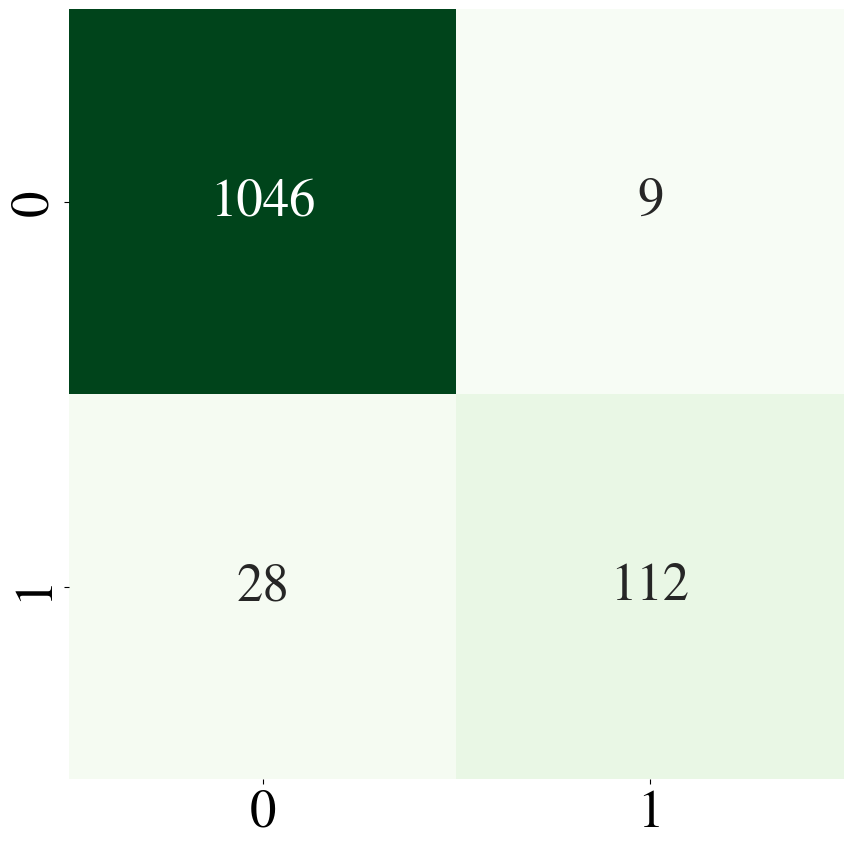

In [20]:
plot_confusion_matrix(y_test,y_pred_best,"Best features set")

In [ ]:
cls = grid_search.best_estimator_

In [ ]:
explainer_tree = shap.TreeExplainer(cls.named_steps['classifier'])
shap_values_tree = explainer_tree.shap_values(df_X_test_full)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [ ]:
def get_shaps(classifier, dataset):
    print(dataset.shape)
    explainer = shap.Explainer(classifier, dataset)
    shap_values = explainer(dataset,check_additivity=False)

    explainer_tree = shap.TreeExplainer(classifier)
    shap_values_tree = explainer_tree.shap_values(dataset)
    return shap_values,shap_values_tree

In [ ]:
def plot_beeswarn(df,shap_values,filename,class_index=1):
    shap.summary_plot(shap_values[class_index], df,show=False,max_display=10,color='red',color_bar=True,class_names=True)
    fig = plt.gcf() # gcf means "get current figure"
    ax = plt.gca() #gca means "get current axes"

    fig.axes[1].yaxis.get_label().set_fontsize(24)
    # fig.axes[1].set_fontsize(24)
    plt.xlabel('SHAP value',fontsize=20)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.tight_layout()
    plt.savefig('{}.png'.format(filename))

In [ ]:
explainer = shap.Explainer(cls.named_steps['classifier'], df_X_test_full)
shap_values = explainer(df_X_test_full,check_additivity=False)

 98%|===================| 1169/1195 [00:15<00:00]       

In [ ]:
shap_values, shap_values_tree = get_shaps(cls.named_steps['classifier'], df_X_test_full)

(1195, 43)


 95%|=================== | 1131/1195 [00:15<00:00]       LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


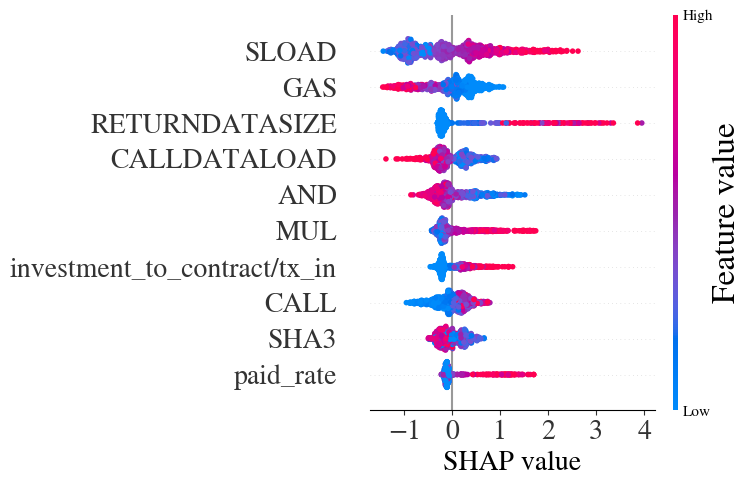

In [ ]:
plot_beeswarn(df_X_test_full,shap_values_tree,'total',1)

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

In [ ]:
top_ten = [
 'SLOAD',
 'GAS',
 'RETURNDATASIZE',
 'CALLDATALOAD',
 'AND',
 'MUL',
 'investment_to_contract/tx_in',
 'CALL',
 'SHA3',
 'paid_rate'
]

In [ ]:
for x in best_set:
  PartialDependenceDisplay.from_estimator(
    cls, X_test, [x])

In [ ]:
len(top_ten)

10

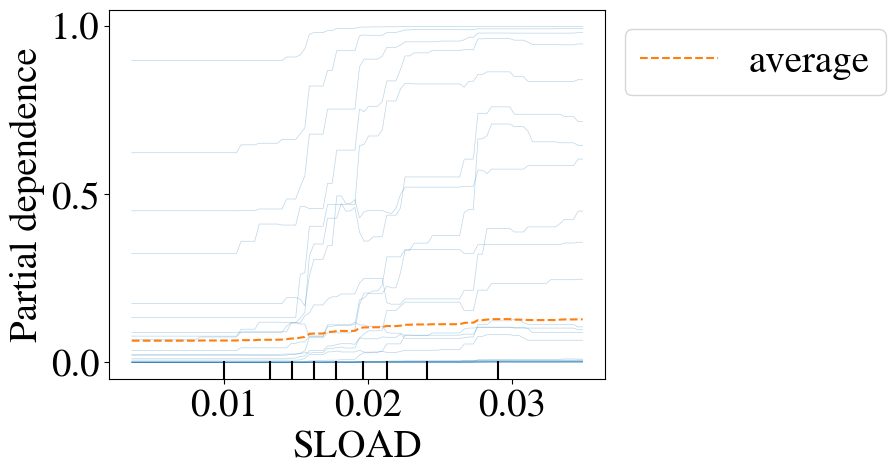

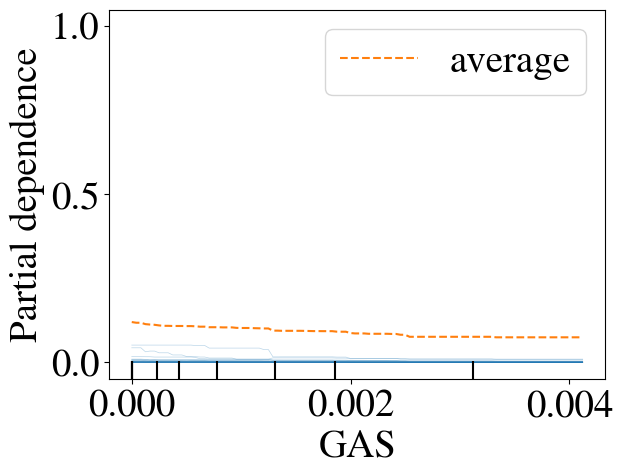

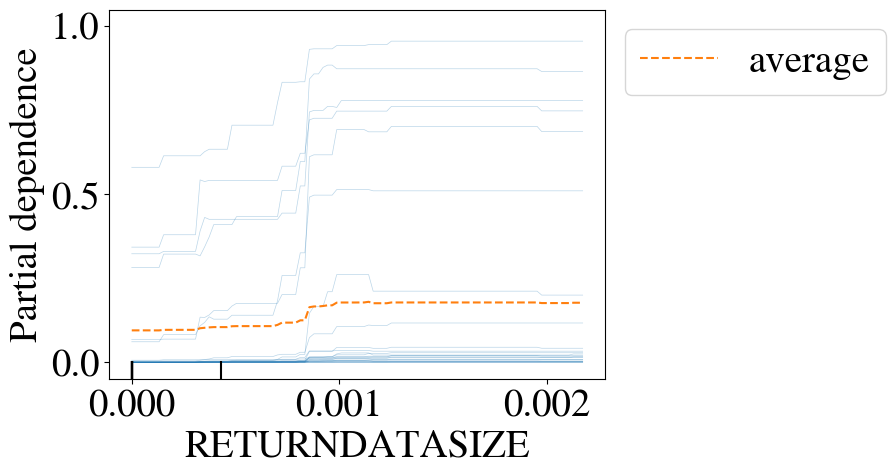

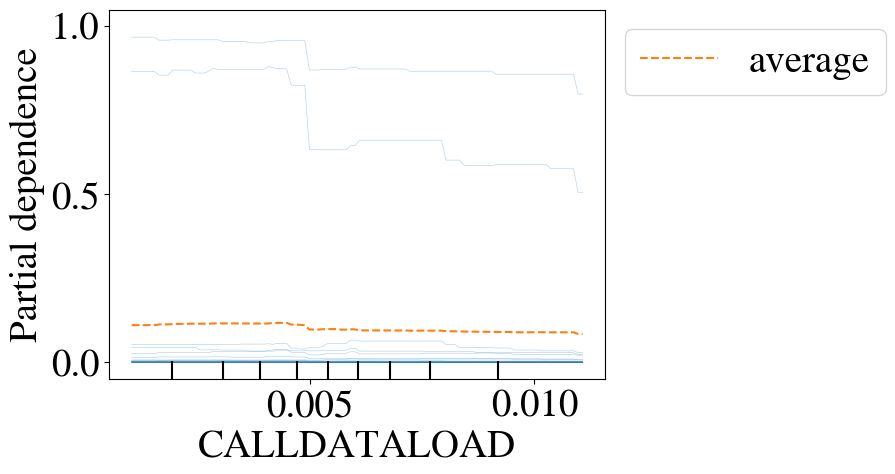

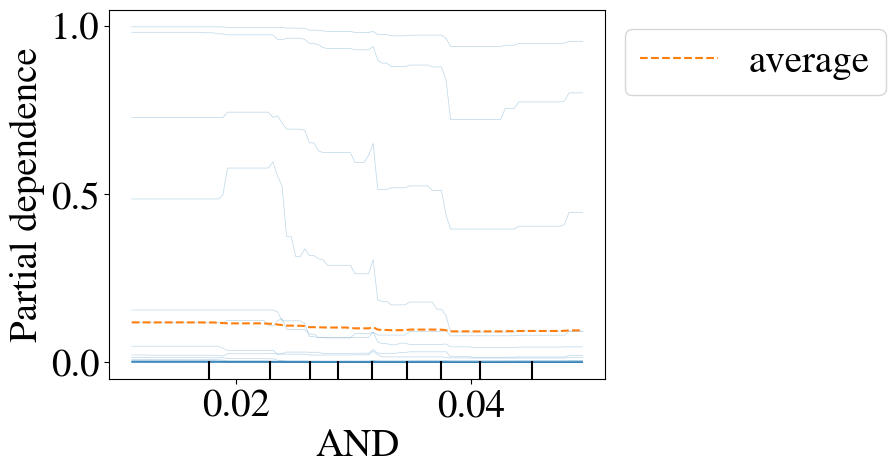

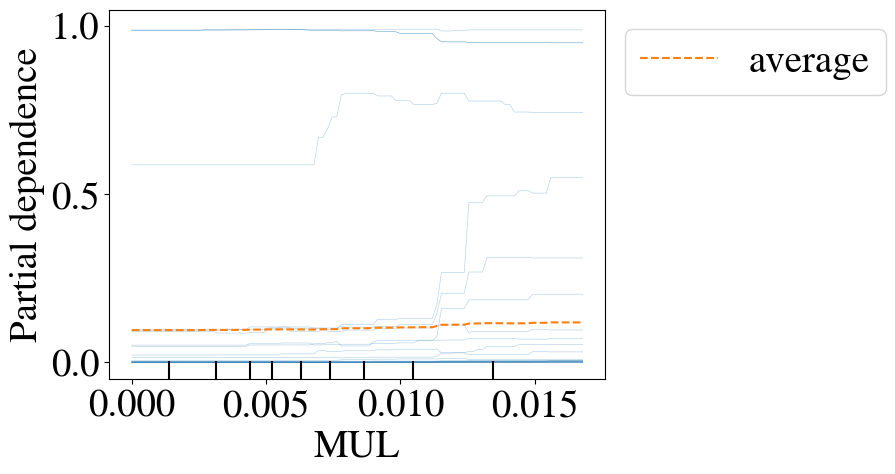

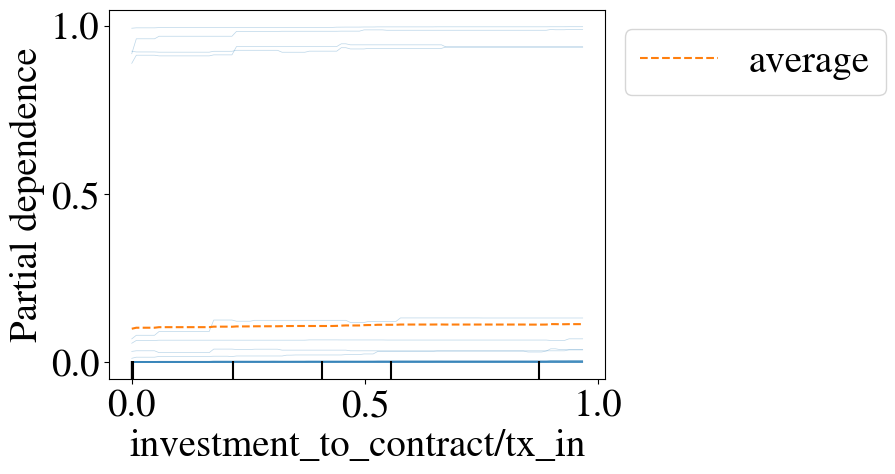

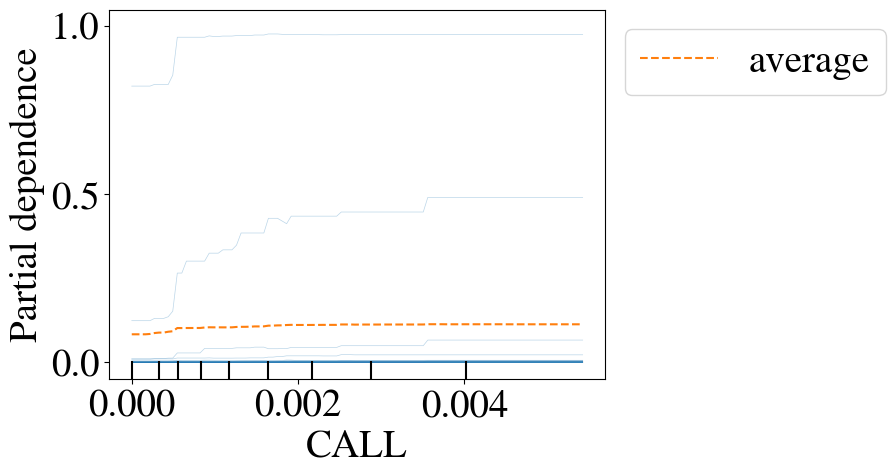

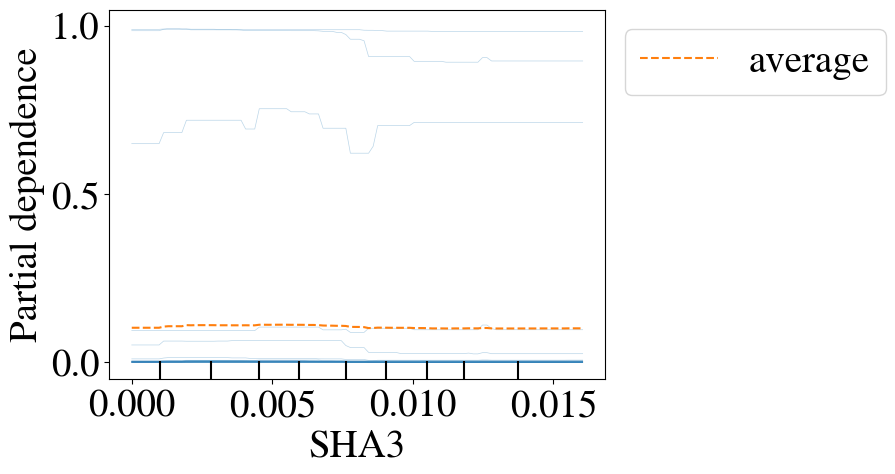

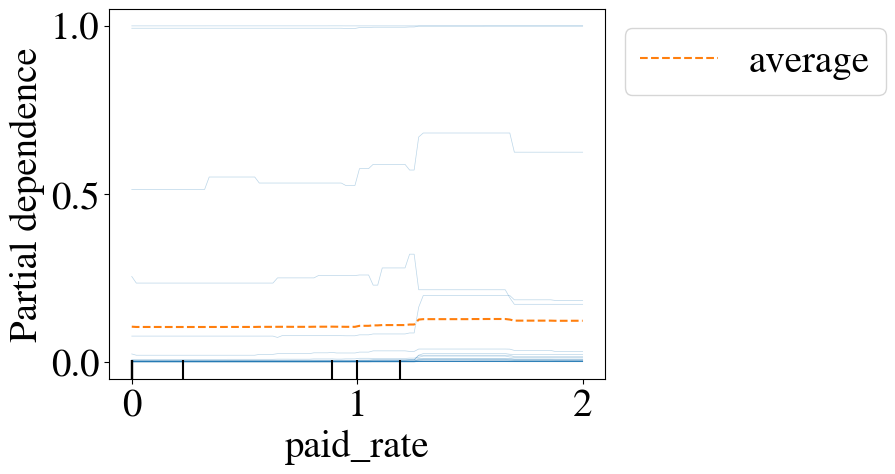

In [ ]:
n = 25
for x in top_ten:
  PartialDependenceDisplay.from_estimator(
    cls, df_X_test_full, [x], kind="both", n_jobs=3, subsample=n
  )
  plt.legend(bbox_to_anchor=(1,1));

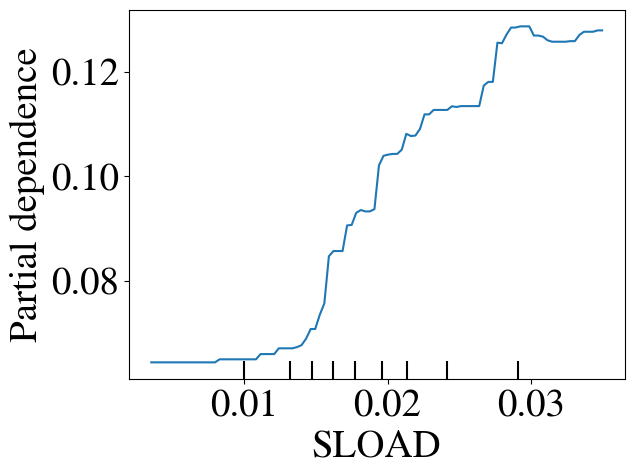

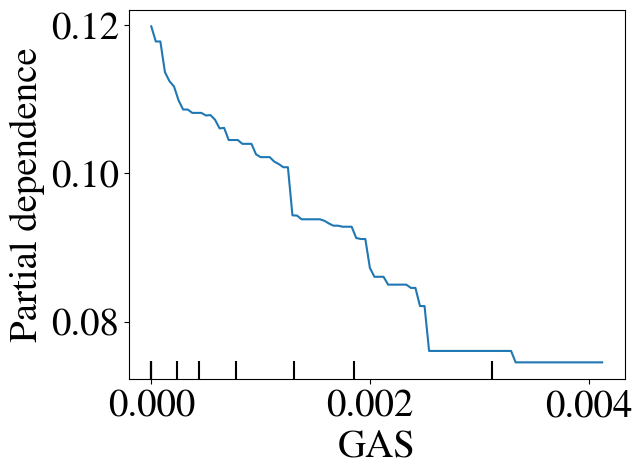

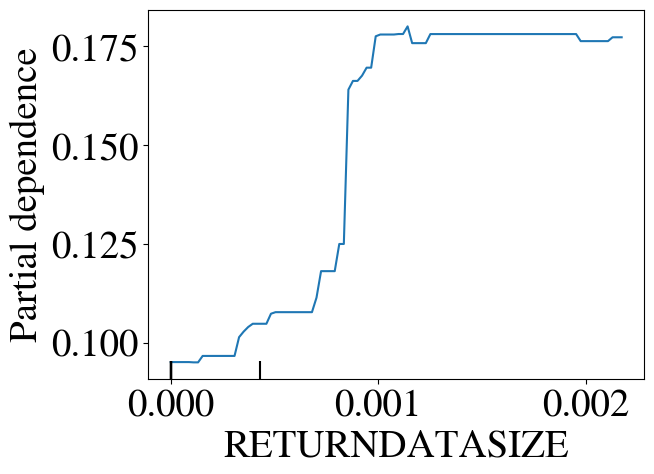

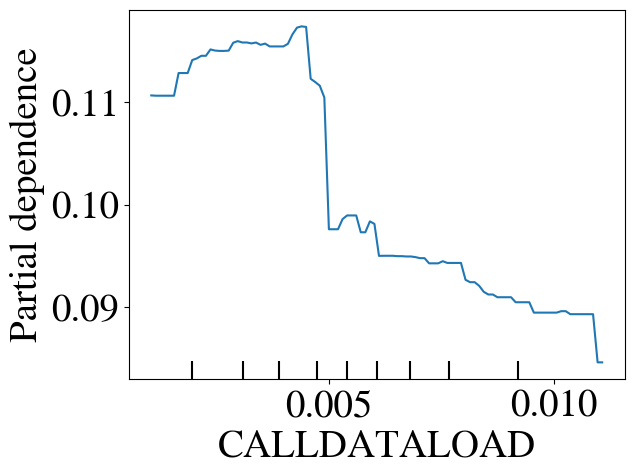

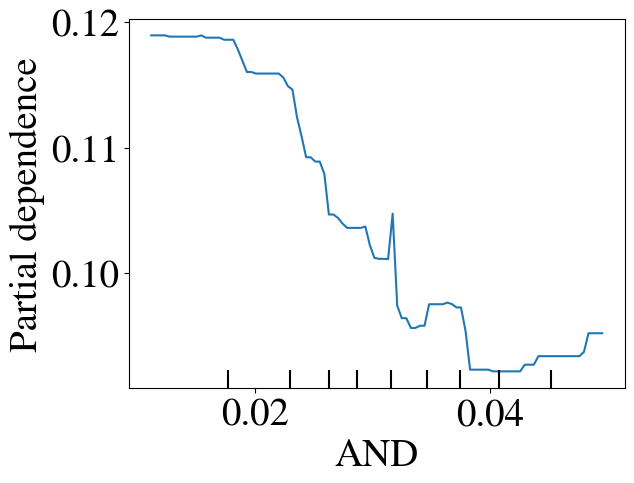

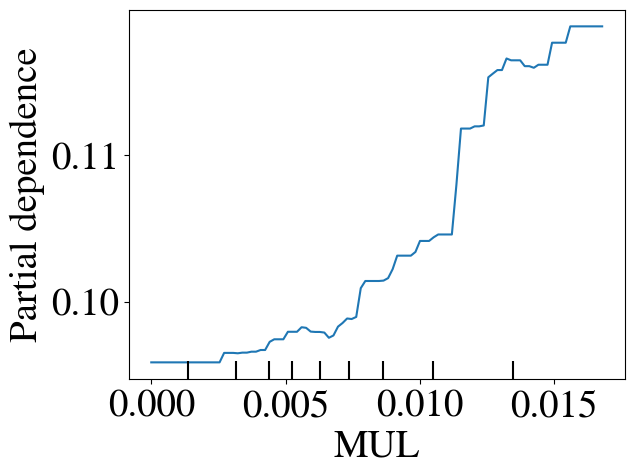

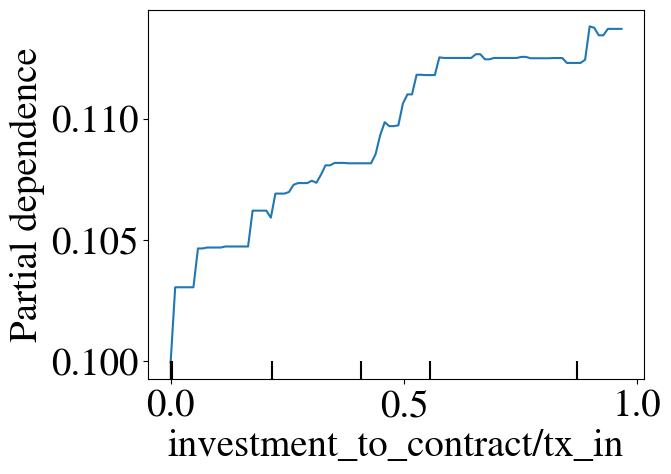

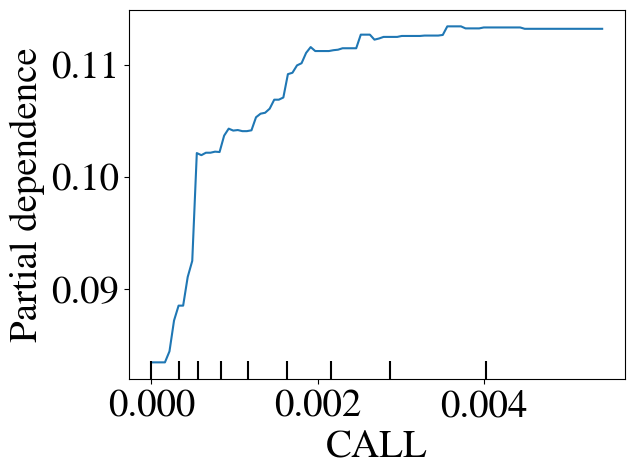

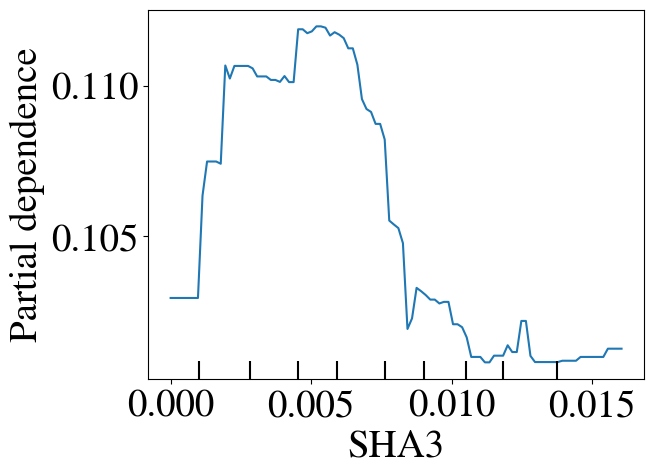

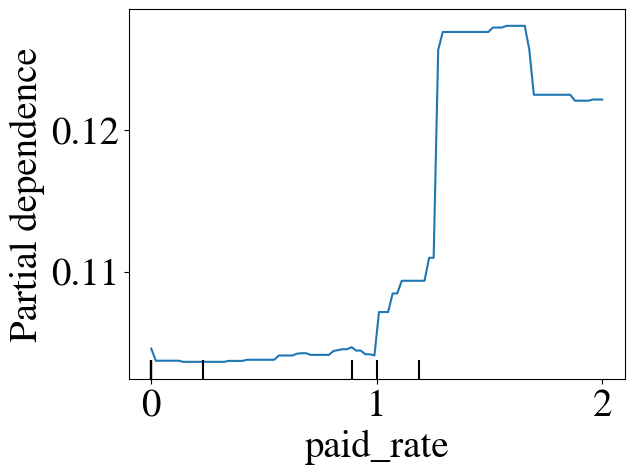

In [ ]:
for x in top_ten:
  PartialDependenceDisplay.from_estimator(
    cls, df_X_test_full, [x])